## 1 | Imports

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from functions import *
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder, Normalizer, MinMaxScaler
from sklearn import preprocessing
import scipy.stats as stats

warnings.filterwarnings('ignore')

## 2 | Working on the dataset

### Cleaning the data

In [2]:
rent_df = pd.read_csv('/Users/ignaciolorenzoqueralt/Documents/Ironhack/Final Project/properties/rent/2021.11.10_cataluña_900_10.csv', engine='python' )
rent_df = rent_df.loc[:, ~rent_df.columns.str.contains('^Unnamed')]

In [3]:
rent_df.head(3)

,area,ccaa,description,geo_town,last_update,lift,m2,n_bath,n_rooms,name,neighborhood,opportunity,price,price_m2,price_reduction,province,url
0,Arenys de Mar,cataluña,INMUEBLE NO SUJETO A LA LIMITACIÓN DE PRECIOS ...,arenys_de_mar,8.0,NaN,70,1,3,Alquiler Apartamento N ii junquera. Alquiler ...,Urbanitzacions,yes,980,14,120.0,barcelona,https://www.habitaclia.com/alquiler-apartament...
1,Arenys de Mar,cataluña,Vivienda en la Urbanización Carolines de Areny...,arenys_de_mar,2.0,yes,89,1,2,"Alquiler Piso en Carrer mig (del), 20. Vivie...",Urbanitzacions,no,680,7,20.0,barcelona,https://www.habitaclia.com/alquiler-piso-vivie...
2,Arenys de Mar,cataluña,ALQUILER DE TEMPORADA - Bonito piso de 70 m2 t...,arenys_de_mar,11.0,NaN,70,1,3,Alquiler Apartamento Carrer camí ral del caba...,Urbanitzacions,no,980,14,10.0,barcelona,https://www.habitaclia.com/alquiler-apartament...


In [4]:
rent_df.shape

(3307, 17)

In [5]:
clean_last_update(rent_df, c = 'last_update')

In [6]:
def fill_lift_column(df):
    return df['lift'].fillna('no', inplace = True)

In [7]:
rent_df.shape

(3307, 17)

In [8]:
fill_lift_column(rent_df)

In [9]:
rent_df = rent_df.dropna()

In [10]:
rent_df.shape

(3270, 17)

In [11]:
checking_nulls(rent_df)

,area,ccaa,description,geo_town,last_update,lift,m2,n_bath,n_rooms,name,neighborhood,opportunity,price,price_m2,price_reduction,province,url


In [12]:
rent_df.shape

(3270, 17)

In [13]:
numericals = ['m2', 'n_rooms', 'n_bath', 'price_m2', 'price', 'price_reduction', 'last_update']
convet_to_numerical(rent_df, numericals)

In [14]:
rent_df.dtypes

area               object
ccaa               object
description        object
geo_town           object
last_update         int64
lift               object
m2                  int64
n_bath              int64
n_rooms             int64
name               object
neighborhood       object
opportunity        object
price               int64
price_m2            int64
price_reduction     int64
province           object
url                object
dtype: object

Filtering out towns in which there are less than x properties listed.

In [15]:
filtered_towns = list(rent_df['geo_town'].value_counts()[lambda x: x > 30].index)
rent_df_filtered = rent_df[rent_df['geo_town'].isin(filtered_towns)]
rent_df_filtered.shape

(2633, 17)

### Feature selection

We skip neighborhood as it would add too many distinct categorical values which would increase too much the size of the model when encoding it.

In [28]:
model_df = rent_df_filtered[['m2', 'n_rooms', 'n_bath', 'opportunity', 'last_update', 'geo_town', 'province', 'ccaa', 'price', 'lift']].copy()

In [17]:
model_df.head(3)

,m2,n_rooms,n_bath,opportunity,last_update,geo_town,province,ccaa,price,lift
30,75,3,1,no,11,badalona,barcelona,cataluña,775,yes
31,65,2,1,no,7,badalona,barcelona,cataluña,906,yes
32,75,3,1,no,11,badalona,barcelona,cataluña,900,no


### Visualizing the original dataset

opportunity
no     98.0
yes     2.0
Name: opportunity, dtype: float64


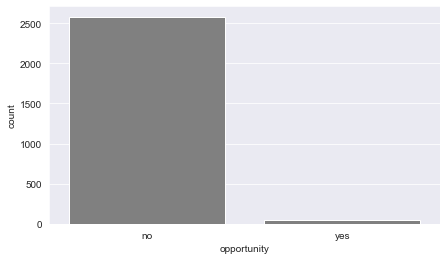

geo_town
barcelona                  54.4
terrassa                    5.4
tarragona                   5.1
sabadell                    4.7
hospitalet_de_llobregat     4.0
manresa                     3.3
reus                        2.9
badalona                    2.7
mataro                      2.2
granollers                  2.1
sitges                      2.1
salou                       2.0
castelldefels               1.5
rubi                        1.5
cambrils                    1.4
mollet_del_valles           1.3
cornella_de_llobregat       1.2
sant_feliu_de_llobregat     1.2
vilanova_i_la_geltru        1.2
Name: geo_town, dtype: float64


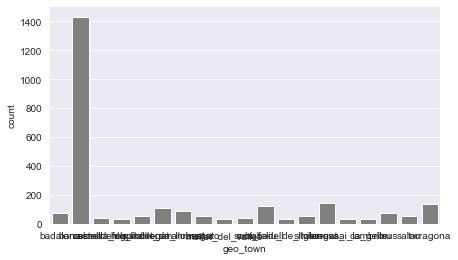

province
barcelona    88.7
tarragona    11.3
Name: province, dtype: float64


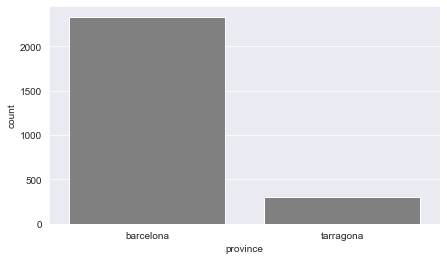

ccaa
cataluña    100.0
Name: ccaa, dtype: float64


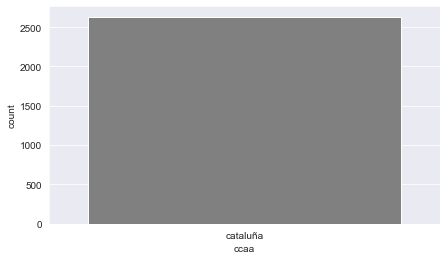

lift
no     54.5
yes    45.5
Name: lift, dtype: float64


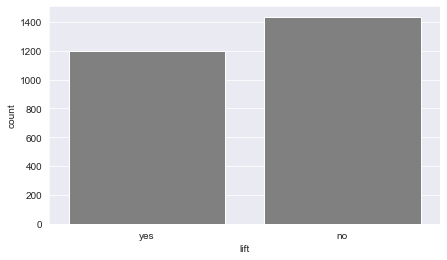

In [18]:
cat_exploration(model_df)

In [22]:
def remove_outliers(df, threshold=1.5, in_columns = [], skip_columns=[]):
    for column in in_columns:
        if column not in skip_columns:
            upper = np.percentile(df[column],75)
            lower = np.percentile(df[column],25)
            iqr = upper - lower
            upper_limit = upper + (threshold * iqr)
            lower_limit = lower - (threshold * iqr)
            df = df[(df[column]>lower_limit) & (df[column]<upper_limit)]
    return df

In [ ]:
in_columns=model_df.select_dtypes(np.number).columns

In [32]:
model_df1 = remove_outliers(model_df, threshold=1.5, in_columns=['price'])

In [33]:
min(model_df['price'])

220

In [34]:
min(model_df1['price'])

412

## 3 | Model

In [35]:
X = model_df1[['m2', 'n_rooms', 'n_bath', 'opportunity', 'last_update', 'geo_town', 'province', 'ccaa', 'lift']].copy()
y = model_df1[['price']].copy()

In [36]:
X_cat = X.select_dtypes('object')
X_num = X.select_dtypes('int')

In [37]:
X_cat_enc = pd.get_dummies(X_cat, drop_first=True)

In [38]:
def boxcox_transform(df):
    numeric_cols = df.select_dtypes(np.number).columns
    _ci = {column: None for column in numeric_cols}
    for column in numeric_cols:
        df[column] = np.where(df[column]<=0, np.NAN, df[column]) 
        df[column] = df[column].fillna(df[column].mean())
        transformed_data, ci = stats.boxcox(df[column])
        df[column] = transformed_data
        _ci[column] = [ci] 
    return df, _ci

X_num_norm, _ci = boxcox_transform(X_num)
X_num_norm.shape, X_cat_enc.shape

((2613, 4), (2613, 21))

In [39]:
scaler = preprocessing.MinMaxScaler()
names = X_num.columns
X_num = scaler.fit_transform(X_num)
X_num_scaled = pd.DataFrame(X_num, columns=names)
X_num_scaled.head()

,m2,n_rooms,n_bath,last_update
0,0.582149,0.235047,0.00000,0.364310
1,0.529952,0.138670,0.00000,0.261939
2,0.582149,0.235047,0.00000,0.364310
3,0.642809,0.311321,0.99317,0.324510
4,0.439178,0.000000,0.00000,0.261939


In [40]:
X_num_norm

,m2,n_rooms,n_bath,last_update
30,7.997931,1.313585,0.000000,4.377752
31,7.563956,0.774974,0.000000,3.147603
32,7.997931,1.313585,0.000000,4.377752
33,8.502275,1.739850,0.138239,3.899491
34,6.809241,0.000000,0.000000,3.147603
...,...,...,...,...
3264,9.770403,1.739850,0.138239,1.939630
3265,8.276868,1.313585,0.000000,3.799920
3266,8.238125,1.313585,0.000000,3.799920
3267,8.819988,1.739850,0.138239,3.799920


In [41]:
X_num_scaled

,m2,n_rooms,n_bath,last_update
0,0.582149,0.235047,0.00000,0.364310
1,0.529952,0.138670,0.00000,0.261939
2,0.582149,0.235047,0.00000,0.364310
3,0.642809,0.311321,0.99317,0.324510
4,0.439178,0.000000,0.00000,0.261939
...,...,...,...,...
2608,0.795334,0.311321,0.99317,0.161413
2609,0.615698,0.235047,0.00000,0.316223
2610,0.611038,0.235047,0.00000,0.316223
2611,0.681022,0.311321,0.99317,0.316223


In [42]:
X = np.concatenate([X_num_scaled, X_cat_enc], axis=1)

In [43]:
X.shape

(2613, 25)

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [45]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [46]:
predictions = model.predict(X_test)
r2 = r2_score(y_test, predictions)
print(r2)

0.5724723754941992
